### Make necessary imports

In [1]:
import sys
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from tqdm import tnrange

sys.path.append('../batchflow')

from batchflow import Config, Pipeline, B, V
from batchflow.opensets import MNIST
from batchflow.models.torch import TorchModel
from batchflow.models.metrics import ClassificationMetrics

### Load dataset

In [2]:
mnist = MNIST()

### Define model configs

In [3]:
config_0 = {
    'inputs/images/shape': (1, 28, 28),
    'inputs/images/data_format': 'channels_first',
    'inputs/images/classes': 10,

    'initial_block/inputs': 'images',
    'body/layout': 'f',
    'body/units': 10,

    'output/predicted': ['proba', 'labels'],
    'optimizer': 'Adam',
    'loss': 'ce',
}

config_1 = config_0 + Config({'body/layout': 'fa f'})

# config_2 = config_0 + Config({'body/activation': 'tanh'})

configs = [config_0, config_1]

### Define train pipelines

In [4]:
def make_train_pipeline(config, dataset):
    train_template = (Pipeline()
        .init_variable('loss', default=[])
        .to_array('float32', 'channels_first')
        .init_model('dynamic', TorchModel, 'model', config)
        .train_model('model', B('images'), B('labels'), fetches='loss', save_to=V('loss', mode='a'))
    )
    return dataset >> train_template

### Run train pipelines

In [5]:
BATCH_SIZE = 64
N_ITERS = 200

train_pipelines = []
for config in configs:
    train_pipeline = make_train_pipeline(config, mnist.train)
    print('Train {} model'.format(train_pipeline.m('model').config['body']))
    train_pipeline.run(batch_size=BATCH_SIZE, n_iters=N_ITERS, bar='n', shuffle=True, drop_last=True)
    train_pipelines.append(train_pipeline)

Train {'layout': 'f', 'units': 10} model



Train {'layout': 'fa f', 'units': 10} model


### Plot models loss

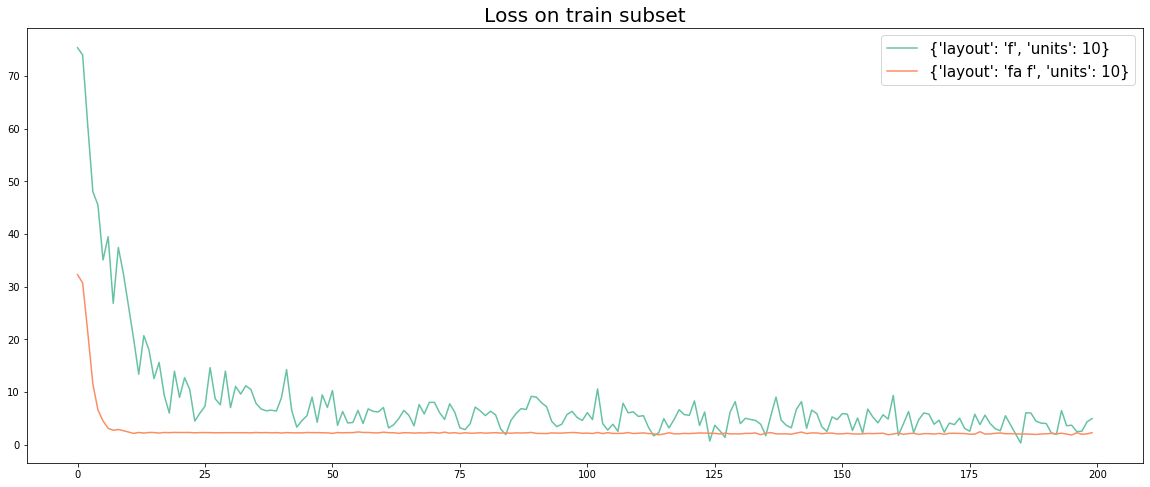

In [6]:
plt.figure(figsize=(20,8))
losses = [np.asarray(train_pipeline.v('loss')) for train_pipeline in train_pipelines]
axes = sns.lineplot(data=losses, palette='Set2', dashes=['']*len(losses)).set_title('Loss on train subset', fontsize=20)
plt.legend([str(ppl.m('model').config['body']) for ppl in train_pipelines], prop={'size': 15});

### Define test pipelines

In [7]:
def make_test_pipeline(train_pipeline, dataset):
    test_template = (Pipeline()
        .init_variable('predictions')
        .init_variable('metrics')
        .import_model('model', train_pipeline)
        .to_array('float32', 'channels_first')
        .predict_model('model', B('images'), fetches='predicted_proba', save_to=V('predictions'))
        .gather_metrics(ClassificationMetrics, targets=B('labels'), predictions=V('predictions'),
                        fmt='logits', axis=1, save_to=V('metrics', mode='u'))
    )
    return dataset >> test_template

### Run test pipelines

In [8]:
test_pipelines = []
for train_pipeline in train_pipelines:
    print('Test {} model'.format(train_pipeline.m('model').config['body']))
    test_pipeline = make_test_pipeline(train_pipeline, mnist.test)
    test_pipeline.run(batch_size=1, n_epochs=1, bar='n')
    test_pipelines.append(test_pipeline)

Test {'layout': 'f', 'units': 10} model



Test {'layout': 'fa f', 'units': 10} model


### Plot confusion matrices for our predictions

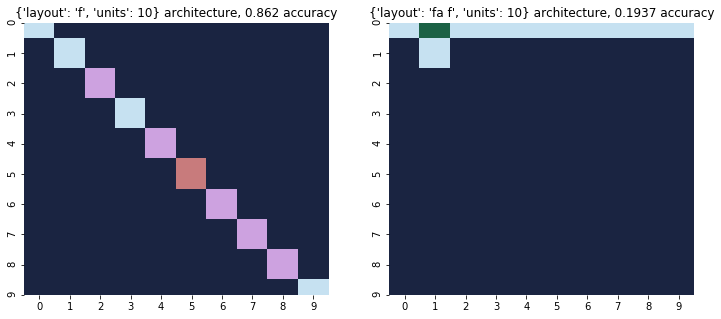

In [9]:
fig, axes = plt.subplots(1, len(configs), figsize=(6 * len(configs), 5))

for ax, test_pipeline in zip(axes, test_pipelines):
    model_body = str(test_pipeline.m('model').config['body'])
    metrics = test_pipeline.get_variable('metrics')
    accuracy = metrics.evaluate('accuracy')
    title = '{} architecture, {} accuracy'.format(model_body, accuracy)
    confusion_matrix = metrics._confusion_matrix.squeeze()
    heatmap = sns.heatmap(confusion_matrix, ax=ax, cmap=sns.color_palette('cubehelix'), cbar=False).set_title(title)

### Reset pipelines and run them again, checking accuracy on test each `N_REPS` iterations

In [10]:
N_REPS = 100
N_ITERS = 10

_ = [train_pipeline.reset(['iter', 'vars', 'models']) for train_pipeline in train_pipelines]
_ = [test_pipeline.reset(['iter', 'vars', 'models']) for test_pipeline in test_pipelines]

accuracies = []
for train_pipeline, test_pipeline in zip(train_pipelines, test_pipelines):
    print('Run {} model'.format(test_pipeline.m('model').config['body']))
    accuracy = []
    for rep in tnrange(N_REPS):
        train_pipeline.run(batch_size=BATCH_SIZE, n_iters=N_ITERS, shuffle=True, drop_last=True)
        
        test_pipeline.reset(['vars'])
        test_pipeline.run(batch_size=100, n_iters=1)
        accuracy.append(test_pipeline.v('metrics').evaluate('accuracy'))
    accuracies.append(np.asarray(accuracy))

Run {'layout': 'f', 'units': 10} model



Run {'layout': 'fa f', 'units': 10} model


### Plot accuracy change on test subset for both our models

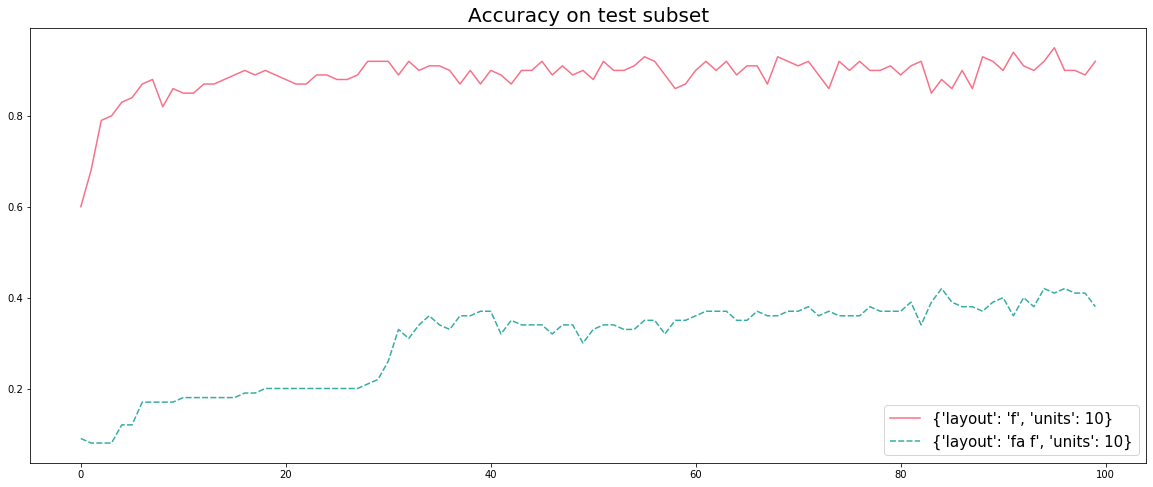

In [11]:
plt.figure(figsize=(20, 8))
sns.lineplot(data=accuracies, palette='husl').set_title('Accuracy on test subset',fontsize=20)
plt.legend([str(ppl.m('model').config['body']) for ppl in train_pipelines], prop={'size': 15});